In [1]:
import impedance as imp
import impedance.circuits as circuits
import impedance.plotting as imp_plot
import impedance.model_io as model_io
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = np.genfromtxt('data/exampleData.csv', delimiter=',')

frequencies = data[:,0]
Z = data[:,1] + 1j*data[:,2]

# keep only the impedance data in the first quandrant
frequencies = frequencies[np.imag(Z) < 0]
Z = Z[np.imag(Z) < 0]



In [3]:
test_circuit = circuits.CustomCircuit(initial_guess=[.01, .005, .1, .005, .1, .001, 200],
                              circuit='R0-p(R1,C1)-p(R2,C2)-W1') 


In [4]:
print(test_circuit)
model_io.model_export(test_circuit, 'template_model.json')


Circuit string: R0-p(R1,C1)-p(R2,C2)-W1
Fit: False

Initial guesses:
     R0 = 1.00e-02 [Ohm]
     R1 = 5.00e-03 [Ohm]
     C1 = 1.00e-01 [F]
     R2 = 5.00e-03 [Ohm]
     C2 = 1.00e-01 [F]
   W1_0 = 1.00e-03 [Ohm]
   W1_1 = 2.00e+02 [sec]



In [5]:
loaded_template = model_io.model_import('template_model.json')

In [6]:
print("Initial Model")
print(test_circuit)
print("Loaded Template")
print(loaded_template)

Initial Model

Circuit string: R0-p(R1,C1)-p(R2,C2)-W1
Fit: False

Initial guesses:
     R0 = 1.00e-02 [Ohm]
     R1 = 5.00e-03 [Ohm]
     C1 = 1.00e-01 [F]
     R2 = 5.00e-03 [Ohm]
     C2 = 1.00e-01 [F]
   W1_0 = 1.00e-03 [Ohm]
   W1_1 = 2.00e+02 [sec]

Loaded Template

Circuit string: R0-p(R1,C1)-p(R2,C2)-W1
Fit: False

Initial guesses:
     R0 = 1.00e-02 [Ohm]
     R1 = 5.00e-03 [Ohm]
     C1 = 1.00e-01 [F]
     R2 = 5.00e-03 [Ohm]
     C2 = 1.00e-01 [F]
   W1_0 = 1.00e-03 [Ohm]
   W1_1 = 2.00e+02 [sec]



Simulating circuit based on initial parameters


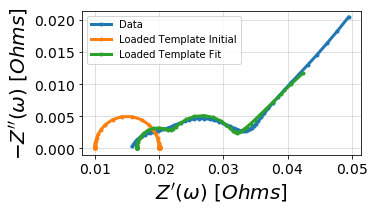

In [7]:
fig, ax = plt.subplots(figsize=(5,5))
f_pred = np.logspace(5,-2)
loaded_template.fit(frequencies, Z)

imported_circuit_init = loaded_template.predict(f_pred, use_initial = True)
imported_circuit_fit = loaded_template.predict(f_pred)

imp_plot.plot_nyquist(ax, frequencies, Z)
imp_plot.plot_nyquist(ax, f_pred, imported_circuit_init)
imp_plot.plot_nyquist(ax, f_pred, imported_circuit_fit)

ax.legend(['Data', 'Loaded Template Initial', 'Loaded Template Fit'])

plt.show()

In [8]:
model_io.model_export(loaded_template, 'fitted_template.json')

In [9]:
fitted_template = model_io.model_import('fitted_template.json', fitted_as_initial=True)

In [10]:
print(fitted_template)


Circuit string: R0-p(R1,C1)-p(R2,C2)-W1
Fit: False

Initial guesses:
     R0 = 1.65e-02 [Ohm]
     R1 = 5.31e-03 [Ohm]
     C1 = 2.32e-01 [F]
     R2 = 8.77e-03 [Ohm]
     C2 = 3.28e+00 [F]
   W1_0 = 6.37e-02 [Ohm]
   W1_1 = 2.37e+02 [sec]



In [22]:
Z2 = (0.005+data[:,1]) + 1j*data[:,2]
Z2 = Z2[np.imag(Z2) < 0]

Simulating circuit based on initial parameters


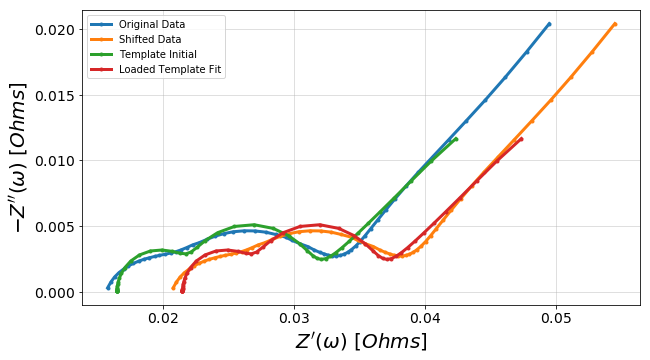

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
f_pred = np.logspace(5,-2)
fitted_template.fit(frequencies, Z2)

imported_circuit_init = fitted_template.predict(f_pred, use_initial = True)
imported_circuit_fit = fitted_template.predict(f_pred)

imp_plot.plot_nyquist(ax, frequencies, Z)
imp_plot.plot_nyquist(ax, frequencies, Z2)
imp_plot.plot_nyquist(ax, f_pred, imported_circuit_init)
imp_plot.plot_nyquist(ax, f_pred, imported_circuit_fit)

ax.legend(['Original Data', 'Shifted Data', 'Template Initial', 'Loaded Template Fit'])

plt.show()